In [22]:
import string
import json
from collections import Counter
import pandas as pd

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


from cybnews.data import get_data, preprocessing, welf_preprocessing, join_text, cc_preprocessing, fnc_preprocessing
from cybnews.model import train_test_split_data, create_new_model, save_model, load_model

In [7]:
#news_cleaned_2018_02_13.csv

# chunksize = 10000

# with pd.read_csv('/Users/ssadegh/Downloads/FakeNewsCorpus-master/news_cleaned_2018_02_13.csv', chunksize=chunksize) as reader:
#     for i, chunk in enumerate(reader):
#         chunk["text"] = chunk["content"]
#         chunk["label"] = chunk["type"]
#         relevant_columns = ['text', 'label', 'title']
#         chunk = chunk[relevant_columns]
#         chunk = chunk[chunk['label'].isin(['reliable', 'fake'])]

#         label_mapping = {'fake': 1, 'reliable': 0}
#         chunk['label'] = chunk['label'].map(label_mapping)

#         mode = 'w' if i == 0 else 'a'
#         header = (i == 0)
#         chunk.to_csv('/Users/ssadegh/Downloads/FakeNewsCorpus-master/processed_news.csv', mode=mode, header=header, index=False)

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [16]:
import pandas as pd
import csv
import sys

# Increase the field size limit
csv.field_size_limit(sys.maxsize)

# Path to the original and temporary CSV files
original_csv_path = '/Users/ssadegh/Downloads/FakeNewsCorpus-master/news_cleaned_2018_02_13.csv'
temp_csv_path = '/Users/ssadegh/Downloads/FakeNewsCorpus-master/temp_news_cleaned.csv'

# Pre-process the CSV to filter out bad lines
print("Starting to pre-process the CSV to filter out bad lines...")
with open(original_csv_path, 'r', encoding='utf-8') as infile, open(temp_csv_path, 'w', encoding='utf-8') as outfile:
    for i, line in enumerate(infile):
        if i % 100000 == 0:
            print(f"Processed {i} lines...")
        try:
            # Attempt to write the line to the new file
            outfile.write(line)
        except Exception as e:
            print(f"Skipping line {i} due to error: {e}")

print("Pre-processing completed.")

# Initialize parameters
chunksize = 10000
fake_count = 0
reliable_count = 0
max_rows = 50000  # since we need a 50-50 ratio, we limit each category to 50,000 rows
fake_samples = []
reliable_samples = []

# Read and process the temporary CSV in chunks
print("Starting to process the temporary CSV in chunks...")
with pd.read_csv(temp_csv_path, chunksize=chunksize, sep=',', engine='python') as reader:
    for i, chunk in enumerate(reader):
        print(f"Processing chunk {i+1}...")
        # Filter relevant columns and rows
        chunk = chunk[['title', 'content', 'type']]
        chunk = chunk[chunk['type'].isin(['reliable', 'fake'])]

        # Map labels
        label_mapping = {'fake': 1, 'reliable': 0}
        chunk['label'] = chunk['type'].map(label_mapping)

        # Handle NaN values by filling them with empty strings and convert to string
        chunk['title'] = chunk['title'].fillna('').astype(str)
        chunk['content'] = chunk['content'].fillna('').astype(str)

        # Combine title and content into a new column 'text'
        chunk['text'] = chunk['title'] + " " + chunk['content']

        # Separate fake and reliable articles
        fake_chunk = chunk[chunk['label'] == 1]
        reliable_chunk = chunk[chunk['label'] == 0]

        # Add to samples if below max_rows
        if fake_count < max_rows:
            fake_samples.append(fake_chunk)
            fake_count += len(fake_chunk)

        if reliable_count < max_rows:
            reliable_samples.append(reliable_chunk)
            reliable_count += len(reliable_chunk)

        # Stop if we have enough samples
        if fake_count >= max_rows and reliable_count >= max_rows:
            print("Collected enough samples.")
            break

print("Processing completed.")

# Concatenate samples and limit to max_rows
print("Concatenating samples...")
fake_samples = pd.concat(fake_samples)[:max_rows]
reliable_samples = pd.concat(reliable_samples)[:max_rows]

# Combine and shuffle the dataset
print("Combining and shuffling the dataset...")
balanced_df = pd.concat([fake_samples, reliable_samples]).sample(frac=1).reset_index(drop=True)

# Save the processed dataset
output_csv_path = '/Users/ssadegh/Downloads/FakeNewsCorpus-master/processed_news.csv'
print(f"Saving the processed dataset to {output_csv_path}...")
balanced_df.to_csv(output_csv_path, index=False, columns=['text', 'label', 'title'])

print("Processing and saving completed.")


Starting to pre-process the CSV to filter out bad lines...
Processed 0 lines...
Processed 100000 lines...
Processed 200000 lines...
Processed 300000 lines...
Processed 400000 lines...
Processed 500000 lines...
Processed 600000 lines...
Processed 700000 lines...
Processed 800000 lines...
Processed 900000 lines...
Processed 1000000 lines...
Processed 1100000 lines...
Processed 1200000 lines...
Processed 1300000 lines...
Processed 1400000 lines...
Processed 1500000 lines...
Processed 1600000 lines...
Processed 1700000 lines...
Processed 1800000 lines...
Processed 1900000 lines...
Processed 2000000 lines...
Processed 2100000 lines...
Processed 2200000 lines...
Processed 2300000 lines...
Processed 2400000 lines...
Processed 2500000 lines...
Processed 2600000 lines...
Processed 2700000 lines...
Processed 2800000 lines...
Processed 2900000 lines...
Processed 3000000 lines...
Processed 3100000 lines...
Processed 3200000 lines...
Processed 3300000 lines...
Processed 3400000 lines...
Processed 3

In [2]:
data_fnc = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/fnc_processed_news.csv')

data_fnc.head()

,text,label,title
0,Are the Culture Wars History?: A Conversation ...,1,Are the Culture Wars History?: A Conversation ...
1,"Blood Collection Chair Market Growth, Top Manu...",1,"Blood Collection Chair Market Growth, Top Manu..."
2,terrorist attack Archives ⋆ Dc Gazette Every n...,1,terrorist attack Archives ⋆ Dc Gazette
3,Christian Life Coach to the Stars Tim Storey T...,0,Christian Life Coach to the Stars Tim Storey T...
4,Israel’s Takeover of the Internet Israel’s Tak...,1,Israel’s Takeover of the Internet


In [4]:
data_fnc.shape

(100000, 3)

In [3]:
duplicateRows_fnc = data_fnc[data_fnc.duplicated()]
duplicateRows_fnc.shape

(8282, 3)

In [4]:
data_fnc_cleaned = data_fnc.drop_duplicates()
print(data_fnc_cleaned.shape)

(91718, 3)


In [28]:
data_fnc_cleaned.isnull().sum()

text                0
label               0
title               0
all_text            0
all_text_cleaned    0
dtype: int64

In [12]:
data_fnc_cleaned.isnull().any()

text     False
label    False
title     True
dtype: bool

In [5]:
data_fnc_cleaned.label.value_counts(normalize=True)

label
1    0.537397
0    0.462603
Name: proportion, dtype: float64

In [6]:
data_fnc_cleaned_preprocd = fnc_preprocessing(data_fnc_cleaned)
# data_fnc_cleaned_preprocd.head()

/Users/ssadegh/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/cybnews/data.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["title"] = data["title"].fillna('').astype(str)
/Users/ssadegh/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/cybnews/data.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data["text"].fillna('').astype(str)
/Users/ssadegh/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/cybnews/data.py:108: SettingWithCo

In [7]:
data_fnc_cleaned_preprocd.head()

,all_text_cleaned,label
0,culture war history conversation andrew hartma...,1
1,blood collection chair market growth top manuf...,1
2,terrorist attack archive ⋆ dc gazette terroris...,1
3,christian life coach star tim storey talk past...,0
4,israel takeover internet israel takeover inter...,1


In [10]:
data_fnc_cleaned_preprocd.shape

(91718, 2)

In [29]:
data_fnc_cleaned.isnull().any()

text                False
label               False
title               False
all_text            False
all_text_cleaned    False
dtype: bool

In [11]:
data_fnc_cleaned_preprocd.to_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/FNC_clean_preprocd.csv', index=False)


In [12]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=43fe9a3e4b2ae7acfe01c585cfcd965502de64c922ac14318440b0c4b361f8f4
  Stored in directory: /Users/ssadegh/Library/Caches/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [ ]:
data_fnc_cleaned.isnull().any()

In [17]:
#dataset integration

data_integ_fnc = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/FNC_clean_preprocd.csv')
data_integ_credcoal = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/CrediCoal_Fake.csv')
data_integ_welf = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/WELFake_Dataset.csv')


In [30]:
data_integ_credcoal = join_text(data_integ_credcoal)
data_integ_welf = join_text(data_integ_welf)


data_integ_credcoal= cc_preprocessing(data_integ_credcoal)
data_integ_welf = welf_preprocessing(data_integ_welf)

/Users/ssadegh/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/cybnews/data.py:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["label"] = data.label.replace(to_replace=['REAL', 'FAKE'], value=[0, 1])


In [32]:
# data_integ_welf.isnull().any() #check no null !

all_text_cleaned    False
label               False
dtype: bool

In [33]:

unified_data = pd.concat([data_integ_fnc, data_integ_credcoal, data_integ_welf], ignore_index=True)


In [35]:
unified_data.isnull().any()
unified_data.isnull().sum()

all_text_cleaned    1
label               0
dtype: int64

In [36]:
unified_data = unified_data.dropna()
unified_data.isnull().any()

all_text_cleaned    False
label               False
dtype: bool

In [37]:
unified_data.to_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/unified_data.csv', index=False)

In [39]:
unified_data.shape

(170186, 2)

In [18]:
data_unified = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/unified_data.csv')


/var/folders/vr/cm2b45810c14ksf_wpnjfcx40000gn/T/ipykernel_65772/3054907089.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_unified = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/unified_data.csv')


In [19]:
data_unified.shape

(170187, 5)

In [21]:
unified_data.head()

,all_text_cleaned,label,Unnamed: 0,title,text
0,culture war history conversation andrew hartma...,1,NaN,NaN,NaN
1,blood collection chair market growth top manuf...,1,NaN,NaN,NaN
2,terrorist attack archive ⋆ dc gazette terroris...,1,NaN,NaN,NaN
3,christian life coach star tim storey talk past...,0,NaN,NaN,NaN
4,israel takeover internet israel takeover inter...,1,NaN,NaN,NaN


In [27]:
unified_data.isnull().sum()

all_text_cleaned    756
label                 0
Unnamed: 0          946
title               952
text                947
dtype: int64

In [24]:
unified_data

unified_data = unified_data.sample(frac=0.01, random_state=42)

print("wait")
X_train, X_test, y_train, y_test  = train_test_split_data(unified_data)
print("for")
model = create_new_model(X_train, y_train)
print("ever")
unified_data
#model = load_model('model.pkl', MODEL_PATH)
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)
test_accuracy

wait
for


AttributeError: 'float' object has no attribute 'lower'

In [3]:
# data_fnc_unprocessed = pd.read_csv('/Users/ssadegh/code/FakeNewsNet/cyb-news/data/corpus_news_sample.csv')
# data_fnc.head()


,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


In [1]:
data_fnc = fnc_preprocessing(data_fnc)
data_fnc.head()


NameError: name 'fnc_preprocessing' is not defined

In [17]:
data_cc = pd.read_csv('/Users/ssadegh/Downloads/FakeNewsNet/cyb-news/data/CrediCoal_Fake.csv')
data_cc.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
data_cc = get_data('/Users/ssadegh/code/FakeNewsNet/dataset/CrediCoal_Fake.csv')

data_cc = join_text(data_cc)
data_cc = cc_preprocessing(data_cc)

data_cc.head()

/Users/ssadegh/.pyenv/versions/3.10.6/envs/cybnews/lib/python3.10/site-packages/cybnews/data.py:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["label"] = data.label.replace(to_replace=['REAL', 'FAKE'], value=[0, 1])


,all_text_cleaned,label
0,smell hillary fear daniel greenfield shillman ...,1
1,watch exact moment paul ryan commit political ...,1
2,kerry go paris gesture sympathy u secretary st...,0
3,bernie supporter twitter erupt anger against d...,1
4,battle new york primary matter primary day new...,0


In [5]:
data = pd.read_csv('/Users/ssadegh/Downloads/FakeNewsNet/cyb-news/data/WELFake_Dataset.csv')
data.head()


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [10]:
data_cc.shape

(6335, 4)

In [5]:
data.shape

(72134, 4)

In [11]:
data_cc.info

<bound method DataFrame.info of       Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fell

In [6]:
data.info

<bound method DataFrame.info of        Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Ba

In [7]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [12]:
data_cc.label.value_counts(normalize=True)

label
REAL    0.500552
FAKE    0.499448
Name: proportion, dtype: float64

In [188]:
data.label.value_counts(normalize=True)

label
1    0.514404
0    0.485596
Name: proportion, dtype: float64

In [19]:
data_cc.isnull().any()

Unnamed: 0    False
title         False
text          False
label         False
dtype: bool

In [20]:
data_cc.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [17]:
duplicateRows_cc = data_cc[data_cc.duplicated()]
duplicateRows_cc.shape

(0, 4)

In [15]:
duplicateRows = data[data.duplicated()]

In [190]:
duplicateRows.shape

(0, 4)

In [191]:
data.isnull().any()

Unnamed: 0    False
title          True
text           True
label         False
dtype: bool

In [192]:
data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [1]:
from cybnews.data import get_data
df = get_data("/Users/ssadegh/Downloads/FakeNewsNet/cyb-news/data/WELFake_Dataset.csv")


In [193]:
data = data.fillna('')

In [194]:
data["all_text"] = data["title"] + " " +  data["text"]

In [195]:
data['text_length'] = data['all_text'].apply(len)
data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


In [196]:
data.groupby('label')['text_length'].mean()

label
0    3565.107286
1    3139.031208
Name: text_length, dtype: float64

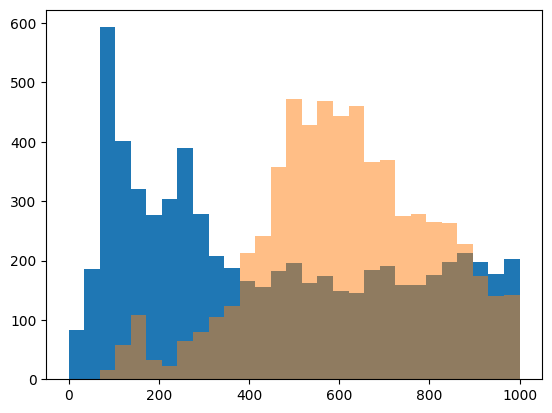

(array([6.358e+03, 5.663e+03, 7.832e+03, 4.112e+03, 3.355e+03, 2.598e+03,
        1.771e+03, 1.331e+03, 7.570e+02, 4.070e+02, 2.120e+02, 1.250e+02,
        7.400e+01, 6.400e+01, 7.100e+01, 3.900e+01, 2.200e+01, 2.800e+01,
        2.100e+01, 2.900e+01, 1.100e+01, 1.700e+01, 8.000e+00, 1.000e+01,
        1.800e+01, 9.000e+00, 1.300e+01, 7.000e+00, 4.000e+00]),
 array([    0.        ,  1034.48275862,  2068.96551724,  3103.44827586,
         4137.93103448,  5172.4137931 ,  6206.89655172,  7241.37931034,
         8275.86206897,  9310.34482759, 10344.82758621, 11379.31034483,
        12413.79310345, 13448.27586207, 14482.75862069, 15517.24137931,
        16551.72413793, 17586.20689655, 18620.68965517, 19655.17241379,
        20689.65517241, 21724.13793103, 22758.62068966, 23793.10344828,
        24827.5862069 , 25862.06896552, 26896.55172414, 27931.03448276,
        28965.51724138, 30000.        ]),
 <BarContainer object of 29 artists>)

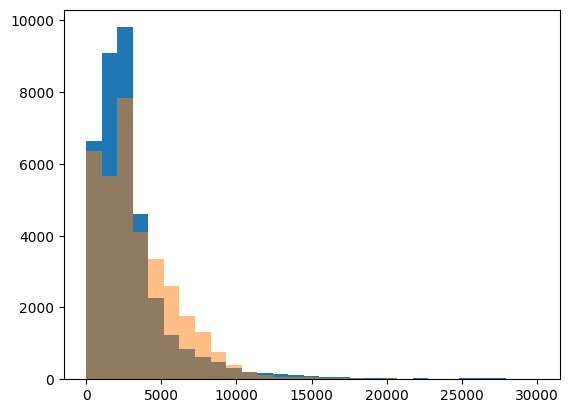

In [197]:
from matplotlib.pylab import plt
import numpy as np

bin = np.linspace(0, 1000, 30)
plt.hist(data[data["label"]== 1]["text_length"], bins=bin)
plt.hist(data[data["label"]== 0]["text_length"], bins=bin, alpha= 0.5)
plt.show();
bin = np.linspace(0, 30000, 30)
plt.hist(data[data["label"]== 1]["text_length"], bins=bin)
plt.hist(data[data["label"]== 0]["text_length"], bins=bin, alpha= 0.5)

In [198]:
# One could argue to only use data["text"] as X


data["all_text"]


data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


In [199]:
# def clean_data(df: pd.DataFrame) -> pd.DataFrame:

In [200]:
# YOUR CODE HERE

"""def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)
    language = set(stopwords.words("english"))
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)
"""


'def preprocessing(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n\n    for x in "’":\n        sentence = sentence.replace(x, "")\n    #for x in \'""\':\n        #sentence = sentence.replace(x, "")\n\n    tokens = word_tokenize(sentence)\n    language = set(stopwords.words("english"))\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]\n    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]\n    return \' \'.join(n_l)\n'

In [201]:
"""import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter


def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)

    language = set(stopwords.words("english"))
    #language.update()
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)"""

'import string\nfrom nltk.corpus import stopwords\nfrom nltk import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\nfrom collections import Counter\n\n\ndef preprocessing(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n\n    for x in "’":\n        sentence = sentence.replace(x, "")\n    #for x in \'""\':\n        #sentence = sentence.replace(x, "")\n\n    tokens = word_tokenize(sentence)\n\n    language = set(stopwords.words("english"))\n    #language.update()\n    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize(word, pos = "

In [228]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

def word_count(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")
    for x in "’":
        sentence = sentence.replace(x, "")
    tokens = word_tokenize(sentence)
    language = set(stopwords.words("english"))
    sentence = [w for  w in tokens if not w in language]
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])

    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    word_counts = Counter(n_l)

    return word_counts

total_word_counts = Counter()
data["all_text_cleaned_test"] = data["all_text"].apply(word_count)
for counts in data["all_text_cleaned_test"]:
    total_word_counts.update(counts)
total = sum(total_word_counts.values())

most_common_words = total_word_counts.most_common(100)
for word, count in most_common_words:
    print(f"{word}: {count}")


say: 3266
“: 2915
”: 2913
trump: 2031
not: 1894
but: 1571
state: 1264
would: 1202
u: 1106
one: 944
people: 889
make: 853
new: 839
mr: 837
clinton: 835
president: 816
time: 799
year: 795
go: 739
no: 672
also: 659
get: 655
take: 633
like: 626
republican: 603
call: 564
—: 558
tell: 550
obama: 533
american: 513
could: 510
come: 498
house: 496
work: 492
use: 491
government: 491
first: 475
white: 475
country: 475
even: 473
two: 472
campaign: 472
against: 456
hillary: 451
right: 449
day: 445
think: 445
election: 442
report: 434
only: 431
know: 428
vote: 421
see: 419
donald: 417
last: 417
many: 409
official: 409
unite: 407
give: 407
news: 406
group: 398
plan: 386
include: 381
need: 379
want: 368
world: 366
way: 363
former: 359
may: 357
back: 353
law: 350
political: 345
show: 343
party: 339
national: 336
become: 335
support: 335
million: 333
try: 328
leave: 327
medium: 324
ask: 320
should: 320
court: 320
week: 318
case: 315
find: 311
email: 311
attack: 310
policy: 307
city: 304
video: 299
york:

23652972

In [227]:
#len(stopwords.words("english"))

print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [204]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter


def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in "’":
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)

    language = set(stopwords.words("english"))
    language.update(["trump", "clinton", "obama"])
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)

In [225]:
data = data.sample(frac=0.1, random_state=42)

In [206]:
data["all_text_cleaned"] = data["all_text"].apply(preprocessing)

In [207]:


data_ready = data[["all_text_cleaned", "label"]]

In [208]:
data_ready


,all_text_cleaned,label
61370,arnold schwarzenegger send message liberal whi...,1
2189,wow “ mexican need kill donald become presiden...,1
60609,jimmy carter recover dehydration scare canada ...,0
51565,friar mission revive brooklyn church religious...,0
39431,boy autism make first friend ever mom cant sto...,1
...,...,...
46006,condemn trump…says u “ bless muslim community ...,1
33197,czech foreign minister lightly injure car acci...,0
61712,house intel slap subpoena mccain institute ass...,1
17836,terror group plan violence against supporter s...,1


In [209]:
y = data_ready["label"]
X = data_ready["all_text_cleaned"]

In [210]:
X.head()

61370    arnold schwarzenegger send message liberal whi...
2189     wow “ mexican need kill donald become presiden...
60609    jimmy carter recover dehydration scare canada ...
51565    friar mission revive brooklyn church religious...
39431    boy autism make first friend ever mom cant sto...
Name: all_text_cleaned, dtype: object

In [211]:
#Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [212]:
X_train

16886    microsoft find cancer clue search query new yo...
63308    kamala harrisleftist senator california next d...
64617    indonesian parliament speaker name suspect mas...
61031    turkey say recognize jerusalem capital would c...
36853    obamas dream america nightmare illegal alien c...
                               ...                        
52834    candidate run president only one pay intern ni...
68373    virginia judge issue new injunction against tr...
10527    right group urge eu japan consider halt fund c...
27342    choose best battery prepper solar system carme...
34276    spacex rocket explode launchpad cape canaveral...
Name: all_text_cleaned, Length: 5049, dtype: object

In [213]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(CountVectorizer(),MultinomialNB())

####
#grid_search
####


In [214]:
pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'multinomialnb__force_alpha': T

In [215]:

grid = {"countvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
        "multinomialnb__alpha": (0.01, 0.1, 1)}


search_g = GridSearchCV(pipe,grid, scoring = "accuracy", cv =5, n_jobs=-1)

search_g.fit(X_train,y_train)


search_g.best_score_

/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/pyt

0.8894845401289386

In [216]:
search_g.best_params_


{'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}

In [217]:
y_pred = search_g.predict(X_test)

In [218]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8932532347504621

In [219]:
# Possible Tokenizer -> Bag of Words, Tf-Idf Embedding, BERT

In [220]:
"""
M
1.Bag of Words (BoW):
Naive Bayes
SVM
Logistic Regression
Random Forest

2.TF-IDF:
Naive Bayes
SVM
Logistic Regression
Random Forest


Deep
3.Word Embeddings:
SVM
Logistic Regression
Deep Learning (LSTM, CNN)
Transformers (prepare=)

4.Transformers:
Deep Learning (LSTM, CNN)
Transformers models"""

'\nM\n1.Bag of Words (BoW):\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n2.TF-IDF:\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n\nDeep\n3.Word Embeddings:\nSVM\nLogistic Regression\nDeep Learning (LSTM, CNN)\nTransformers (prepare=)\n\n4.Transformers:\nDeep Learning (LSTM, CNN)\nTransformers models'

In [221]:
# Insights:
# Model without Obama, Trump and Clinton drops the score